In [1]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)
pd.set_option("display.max_rows", 300) # pandas 가로줄 300개까지 보이도록 설정

1.3.3
1.1.2
0.13.2


# STEP1: 시계열 데이터 준비
- 종가(Close)만 ts 변수에 저장<br>

In [2]:
# Time Series 생성
df = pd.read_csv('hanwha_aerospace_012450.KS.csv', index_col='Date', parse_dates=True)
ts = df['Close'] # 날짜별 종가 정보만 ts : time series에 담아놓습니다
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,48100.0,50400.0,48100.0,50200.0,49452.339844,501866
2021-10-01,49900.0,53300.0,49900.0,52000.0,51225.535156,1081652
2021-10-05,51600.0,52500.0,50900.0,52200.0,51422.554688,631860
2021-10-06,52700.0,52900.0,48000.0,48150.0,47432.875000,1137503
2021-10-07,49200.0,50100.0,48200.0,49700.0,48959.789063,468311


# STEP2: 각종 전처리 수행
- 결측치처리<br>

In [3]:
ts = ts.interpolate(method='time') # 날짜 index를 기준으로 결측값을 보간 시킴

In [4]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 로그변환

In [5]:
ts_log = np.log(ts) # 치우친 데잍터 정규화

결측치가 존재하지 않는것을 확인했습니다.

# STEP3: 시계열 안정성 분석
- 정성적 그래프 분석<br>
- 정량적 Augmented Dicky-Fuller Test<br>
- 시계열 분해(Time Series Decomposition)<br>
- Residual 안정성 확인<br>

In [6]:
# 이동평균 통계
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

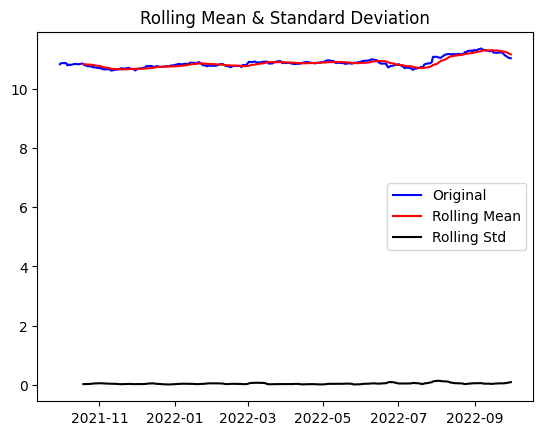

Results of Dickey-Fuller Test:
Test Statistic                  -2.038677
p-value                          0.269876
#Lags Used                       6.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

- 위에 표시된 Dickey-Fuller Test의 p-value = 0.269876 값은 0.05 보다 크므로 ts_log 원본은<br>
  시계열 데이터가 안정적이 않음을 알수있습니다.

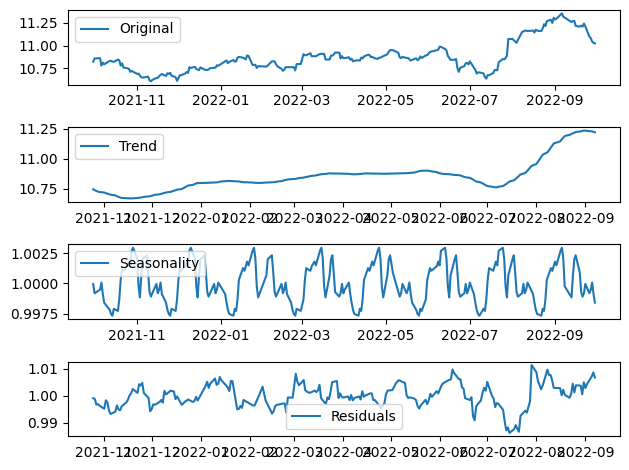

In [8]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

# Residual 안정성 확인
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.216952
p-value                          0.000617
#Lags Used                       0.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


- 하지만 위에 제시된 residual값은 trend와 seasonality를 제거하고 남은 결과 이고<br>
  dickey-Fuller Test에서 p-value=0.000617 값은 0.05보다 작으므로 이정도면 <br>
  확실히 예측가능한 시계열데이터임을 확인할 수 있습니다<br>

# STEP4: 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리<br>

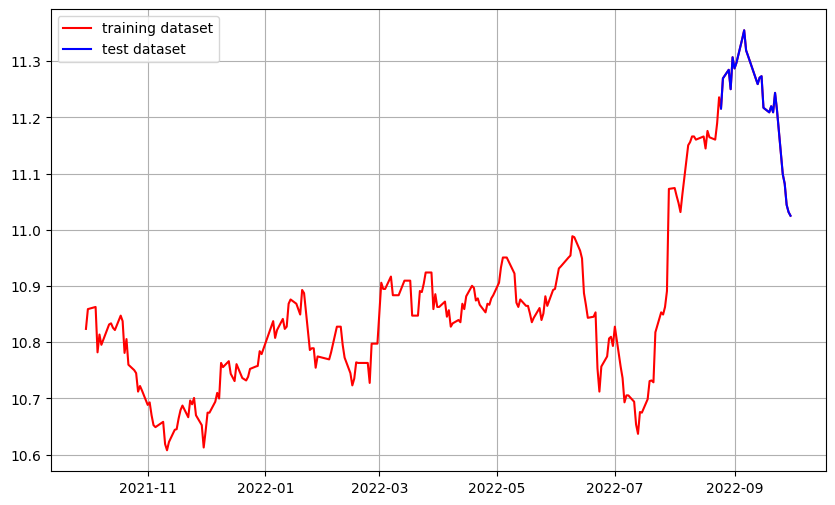

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP5: 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기<br>
- 차분 안정성 확인 -> d 구하기<br>

C:\Users\liky\PRJ\04.AIFFEL\myEnv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


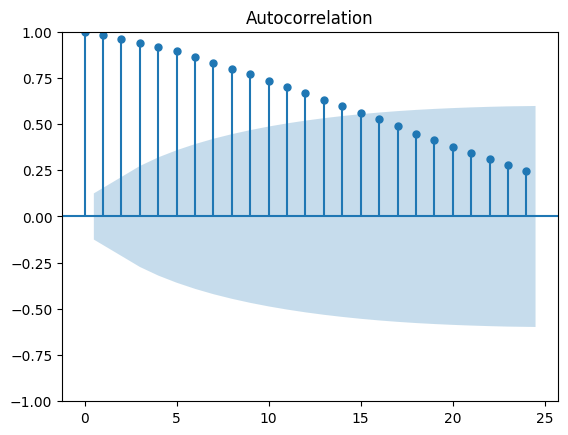

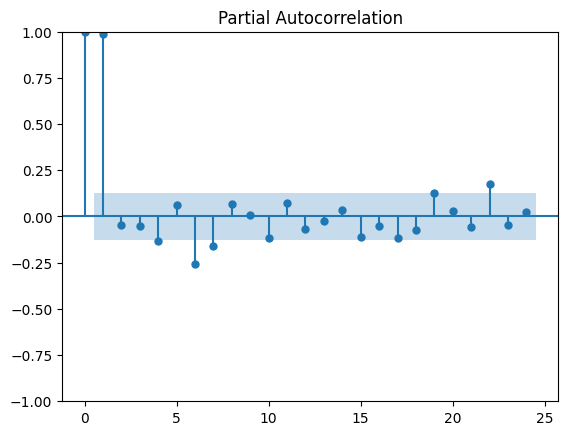

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF 그래프를 통해서 MA 모델은 점차 감소하고 있고<br>
- PACF그래프를 통해서 AR 모델의 시차 p=2 이후에 0이 되므로<br>
  p=2, q=0 으로 모델을 설정해 보겠습니다<br>

Results of Dickey-Fuller Test:
Test Statistic                -1.512967e+01
p-value                        7.262062e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


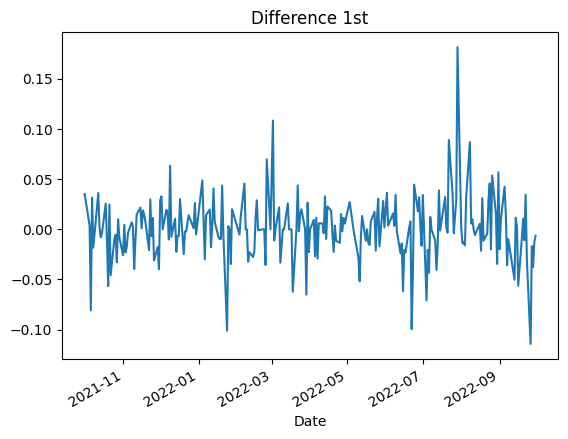

In [12]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

- 1차 차분 구했을때 p-value = 7.262062e-28 로 0.05보다 작아서 안정화 상태로 보입니다.<br>
  그러므로 d=1 부터 시도하겠습니다.

# STEP6: ARIMA 모델 훈련과 테스트
- ARIMA모델 빌드와 훈련<br>
- 모델테스트 및 플로팅<br>
- 최종예측모델정확도측정(MAPE)<br>

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 1, 0)) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 455.986
Date:                Fri, 30 Sep 2022   AIC                           -905.971
Time:                        23:28:52   BIC                           -895.790
Sample:                             0   HQIC                          -901.860
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0299      0.091      0.329      0.742      -0.148       0.208
ar.L2          0.0206      0.068      0.304      0.761      -0.112       0.153
sigma2         0.0009   4.66e-05     19.882      0.0

C:\Users\liky\PRJ\04.AIFFEL\myEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\liky\PRJ\04.AIFFEL\myEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\liky\PRJ\04.AIFFEL\myEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\liky\PRJ\04.AIFFEL\myEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


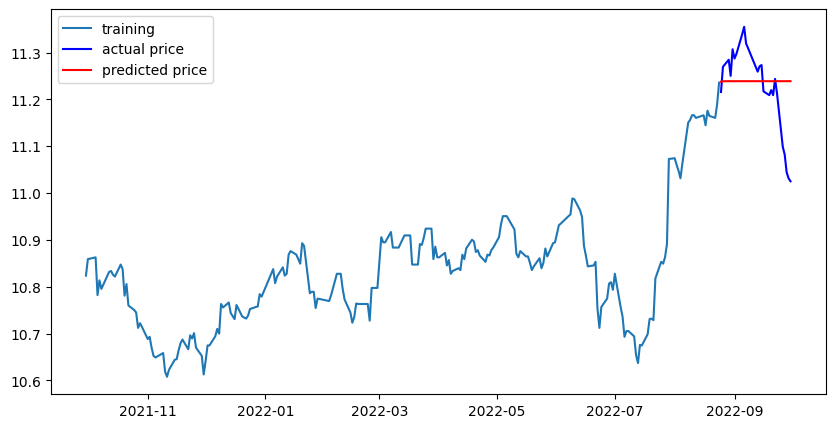

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46473053.76898238
MAE:  5253.011413251653
RMSE:  6817.114768652673
MAPE: 7.40%


In [16]:
# from pyramid.arima import auto_arima
# model = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
# model.fit(train_data)

# forecast = model.predict(n_periods=len(test_data))
# forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])

# #plot the predictions for validation set
# plt.plot(train_data, label='Train')
# plt.plot(test_data, label='Valid')
# plt.plot(forecast, label='Prediction')
# plt.show()